# micrograd

每次我们在 PyTorch 里用 Tensor 做操作时，它会自动构建一张计算图（Computation Graph），每个操作都被当作一个节点（Function）。当调用 .backward() 后，PyTorch 会自动从输出节点出发，按链式法则计算每个变量的梯度，并存入 .grad。

此notebook是follow karpathy walk through, 手动实现了类似pytorch的机制：每个 Value 节点记录了前向操作、父节点、反向函数（链式求导规则），从而实现了 .backward()。

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from graphviz import Digraph

def trace(root):
    """
    从最终输出节点 root 出发，递归回溯整个计算图，
    收集所有 Value 节点和它们之间的依赖关系（边）。
    """
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)  # 加入当前节点
            for child in v._prev:  # 遍历它的前驱节点
                edges.add((child, v))  # 添加边：child -> v
                build(child)  # 递归继续向上回溯

    build(root)
    return nodes, edges  # 返回所有节点和边

 
def draw_dot(root):
    """
    画出从 root 出发的整个计算图（使用 graphviz），
    节点显示其 data 值，若是计算节点还显示操作符。
    """
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # 从左向右画图

    nodes, edges = trace(root)  # 追踪图中的所有节点与边

    for n in nodes:
        uid = str(id(n))  # 使用对象唯一 ID 作为图中节点名称，防止重复

        # 创建一个表示变量数值的矩形节点
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )

        # 如果这个值是由某个操作生成的，插入一个操作节点
        if n._op:
            dot.node(name=uid + n._op, label=n._op)  # 操作符节点（如 +, *, relu）
            dot.edge(uid + n._op, uid)  # 操作 -> 输出值

    for n1, n2 in edges:
        # 将边连接到操作符节点，而不是值节点本身
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


求导：不写表达式，导数的定义是在一处，稍微增加少量 h,函数值的灵敏程度

In [37]:
class Value:
    def __init__(self,data,_children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = _children
        self._op = _op
        self.label = label
        self._backward =  lambda: None
    
    def __repr__(self,):
        return f"Value(data ={self.data})"
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data,(self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __radd__(self, other):
        return self + other             
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        out = self + (-other)
        return out
    
    def __rsub__(self, other):
        return Value(other) - self
   
    def __mul__(self,other):
        other = other if isinstance(other ,Value) else Value(other)
        out = Value(self.data * other.data,(self,other), '*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other 
    
    def __pow__(self, other):
        assert isinstance(other,(int,float)),"only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += out.grad * other * self.data**(other-1)
        
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh (self):
        # self = self if isinstance(self, Value) else Value(self)多此一举了
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) +1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += out.grad * (1-t**2)

        out._backward = _backward
        return out
    
    def exp (self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.grad *out.data
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        for node in reversed (topo):
            node._backward()



        
# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label = 'c')
# f = Value(-2, label='f')
# e = a*b; e.label = 'e'

# d = e + c; d.label ='d'
# d._prev

# L = d * f ;L.label ='L'
 

In [ ]:
# from draw_graph import draw_dot
# draw_dot(L)

In [ ]:
# L.grad = 1.0


In [201]:
# 导数数值计算器
def lol():
    h = 0.00001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label = 'c')
    f = Value(-2, label='f')
    e = a*b; e.label = 'e'
    d = e + c; d.label ='d'
    d._prev
    L = d * f ;L.label ='L'
    L1 = L.data #确保为有效节点

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label = 'c')
    f = Value(-2, label='f')
    e = a*b; e.label = 'e'
    d = e + c; d.label ='d'
    d._prev
    L = d * f ;L.label ='L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

6.000000000128124


In [ ]:
# plt.plot(np.arange(-5,5,0.22), np.tanh(np.arange(-5, 5, 0.22)))
# plt.grid()
# plt.show()

In [7]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh() ;o.label = 'o'




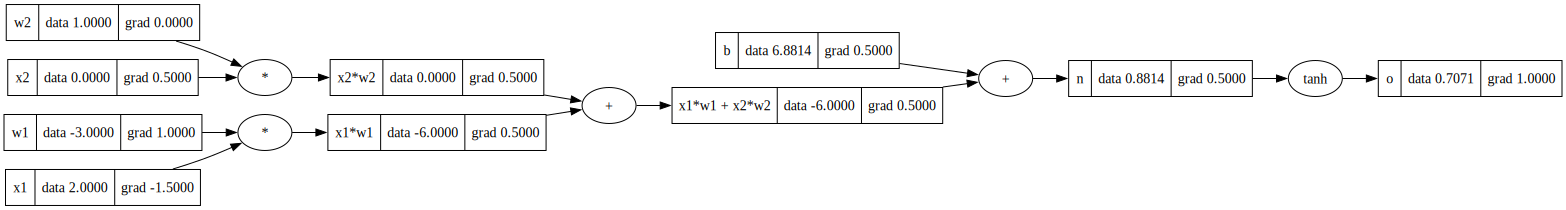

In [186]:
draw_dot(o)

In [ ]:
# o.grad = 1.0
# #梯度等于上游梯度乘以local梯度


In [ ]:
# #手动反向传播梯度，比较低效。很自然想法，在Value类里设置self._backward,每一种运算的方法设置对应的反向传播规则，
# n.grad = 0.5#do/dn = 1-o**2
# b.grad =  0.5
# x1w1x2w2.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad



### 递归
很自然的想法，在类里面定义 _backward属性，lambda闭包函数，每种运算分别实现，运用递归思想

In [ ]:

# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# w1._backward()
# x1._backward()
# w2._backward()
# x2._backward()


### 问题
注意这里的逻辑,会自动执行._backward()
不过这样依然很蠢，需一步一步调用

### 拓扑排序
- 我们之前已经成功构造了数学表达式的前向传播及其计算图谱，但在反向传播，我们也要想办法得到类似的功能
- 在bp过程，每个节点的bp,都必须确保其依赖变量的完整，也就是说其上游梯度
- 因此，这种图的排序可以用拓扑排序实现

In [8]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

topo


[Value(data =2.0),
 Value(data =-3.0),
 Value(data =-6.0),
 Value(data =0.0),
 Value(data =1.0),
 Value(data =0.0),
 Value(data =-6.0),
 Value(data =6.881373587019543),
 Value(data =0.8813735870195432),
 Value(data =0.7071067811865476)]

In [9]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed (topo):
    node._backward()


### 封装
现在将上面的拓扑排序封装到Value类中的backward方法里，即可调用实现反向传播


In [10]:
o.backward()

### Bug
1. 当多次使用同一个变量构造函数表达式时，梯度会被覆盖，于是将梯度改成+=累积即可
2. 我门无法定义所有函数，只需利用基本函数相互组合即可表示所有函数，但如果有常数项参与组合(不是Value类)，报AttributiveError的错。此时应该写方法重载（注意其原理）

### 进一步完善函数:除，次方


下面用指数重新定义o,数学上等价，反向到头的梯度应与上图一样

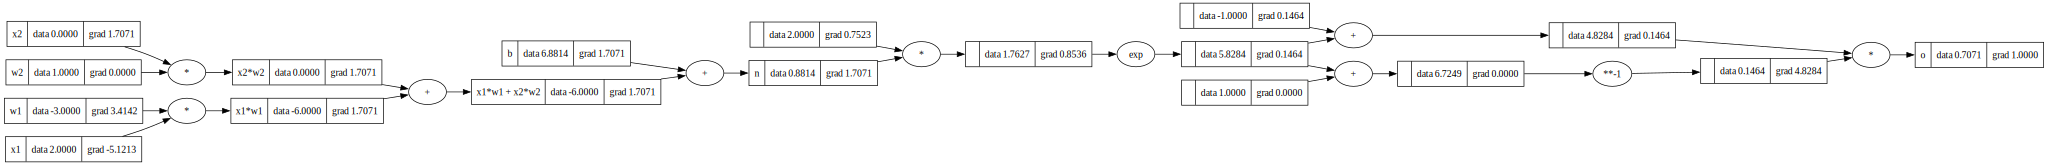

In [11]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh() ;o.label = 'o'
###########################################################
e = (2*n).exp()
o = (e - 1)/(e + 1)
#########################################################
o.label = 'o'
o.backward()
draw_dot(o)

### 总结
这个自动求微分框架在数学上利用链式法则，在代码实现上利用递归。只要能够解决一个节点的前向传播，找到当前节点的上游梯度和local梯度，就可以利用拓扑排序依次实现

# Pytorch
与microgra的Value数据类型不同,Pytorch的数据类型为更复杂的tensor类型,其余道理差不多

In [12]:
import torch
x1 = torch.Tensor([2.0]).double()                        ;x1.requires_grad = True  # python默认双精度(float64),pytorch默认单精度(float32),用double相一致
x2 = torch.Tensor([0.0]).double()                        ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                       ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                        ;w2.requires_grad = True
b = torch.Tensor([6.881373580195432]).double()           ;b.requires_grad = True
#实际上这种写法多一点
# # 构造输入张量，开启 requires_grad
# x1 = torch.tensor([2.0], dtype=torch.float64, requires_grad=True)
# x2 = torch.tensor([0.0], dtype=torch.float64, requires_grad=True)
# w1 = torch.tensor([-3.0], dtype=torch.float64, requires_grad=True)
# w2 = torch.tensor([1.0], dtype=torch.float64, requires_grad=True)
# b = torch.tensor([6.8813735870195432], dtype=torch.float64, requires_grad=True)

#forward
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())

# BP
o.backward()

# 打印梯度
print('___')
print('x2', x2.grad.item())   # 这里也需要注意，.item()和.data.item()的结果是一样的
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
___
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# 构建nn


### 用micograd

In [13]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))

    def __call__(self,x):
        act = sum((wi*xi for wi ,xi in zip(self.w,x)), self.b) #注意这行代码的逻辑sum(iterable, start)
        # nin = len(x)
        # act = sum(self.w[i] * x[i] for i in range(nin)) + self.b 
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range (nout)]


    def __call__(self,x):
        # outs = [self.neurons[i](x) for i in range (len(self.neurons))]，这种写法不够Pythonic
        outs = [n(x) for n in self.neurons]                       
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        parameters = [p for neuron in self.neurons for p in neuron.parameters()]
        # parameters = []
        # for neuron in self.neurons:
        #     p = neuron.parameters()
        #     parameters.extend(p)
        return parameters
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i + 1]) for i in range (len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        parameters = [p for layer in self.layers for p in layer.parameters()]
        return parameters

        # parameters = []
        # for layer in self.layers:
        #     p = layer.parameters()
        #     parameters.extend(p)
        # return parameters
        


In [14]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data =-0.9542210807000369)

### cache
这里新添加了参数的储存

In [17]:
n.parameters()

[Value(data =-0.1818926277642432),
 Value(data =0.22336178574386256),
 Value(data =0.07295275804074386),
 Value(data =0.5874676727143886),
 Value(data =-0.06310422260713966),
 Value(data =-0.6667598050266568),
 Value(data =0.21763098003200487),
 Value(data =-0.4290665019042754),
 Value(data =-0.30367476541226623),
 Value(data =0.16801138645080238),
 Value(data =-0.2990368196795432),
 Value(data =-0.6842733054995778),
 Value(data =0.08169214215541198),
 Value(data =0.44938662824968767),
 Value(data =-0.9601328391447053),
 Value(data =0.8659935050154228),
 Value(data =-0.8129272179425764),
 Value(data =-0.512070815844657),
 Value(data =-0.9925480259486896),
 Value(data =-0.8257473563331992),
 Value(data =0.7580399786920626),
 Value(data =0.5173429870442943),
 Value(data =0.14532035418032452),
 Value(data =0.11584355897319432),
 Value(data =-0.19609921941433628),
 Value(data =-0.27885106016283734),
 Value(data =0.5251058719953758),
 Value(data =-0.9610740988671056),
 Value(data =0.5988077

### 手动训练
一下代码可以一步一步手动前/反传播以及梯度更新，有点混乱,数据应该是假的，看似结果很好，但新梯度时没有事先清空梯度，导致每一步跟新幅度很大，正确写法见下面自动训练

In [48]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0,0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]


ypred = [n(x) for x in xs]
ypred


[Value(data =0.9999256221331054),
 Value(data =-0.9999670141294603),
 Value(data =-0.9999641787809469),
 Value(data =0.999943800294271)]

the trick used in deeplearning to achieve this is to calculate a single number that somehow measures the total performance of nn,we call the single number the loss

In [45]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys ,ypred)], start=Value(0.0))
loss

Value(data =1.495740197105874e-08)

In [ ]:
loss.backward()


In [47]:
for p in n.parameters():
    p.data += -0.01 * p.grad


In [23]:
n.layers[0].neurons[0].w[0].data

-0.1818926277642432

In [22]:
n.layers[0].neurons[0].w[0].grad

0.0

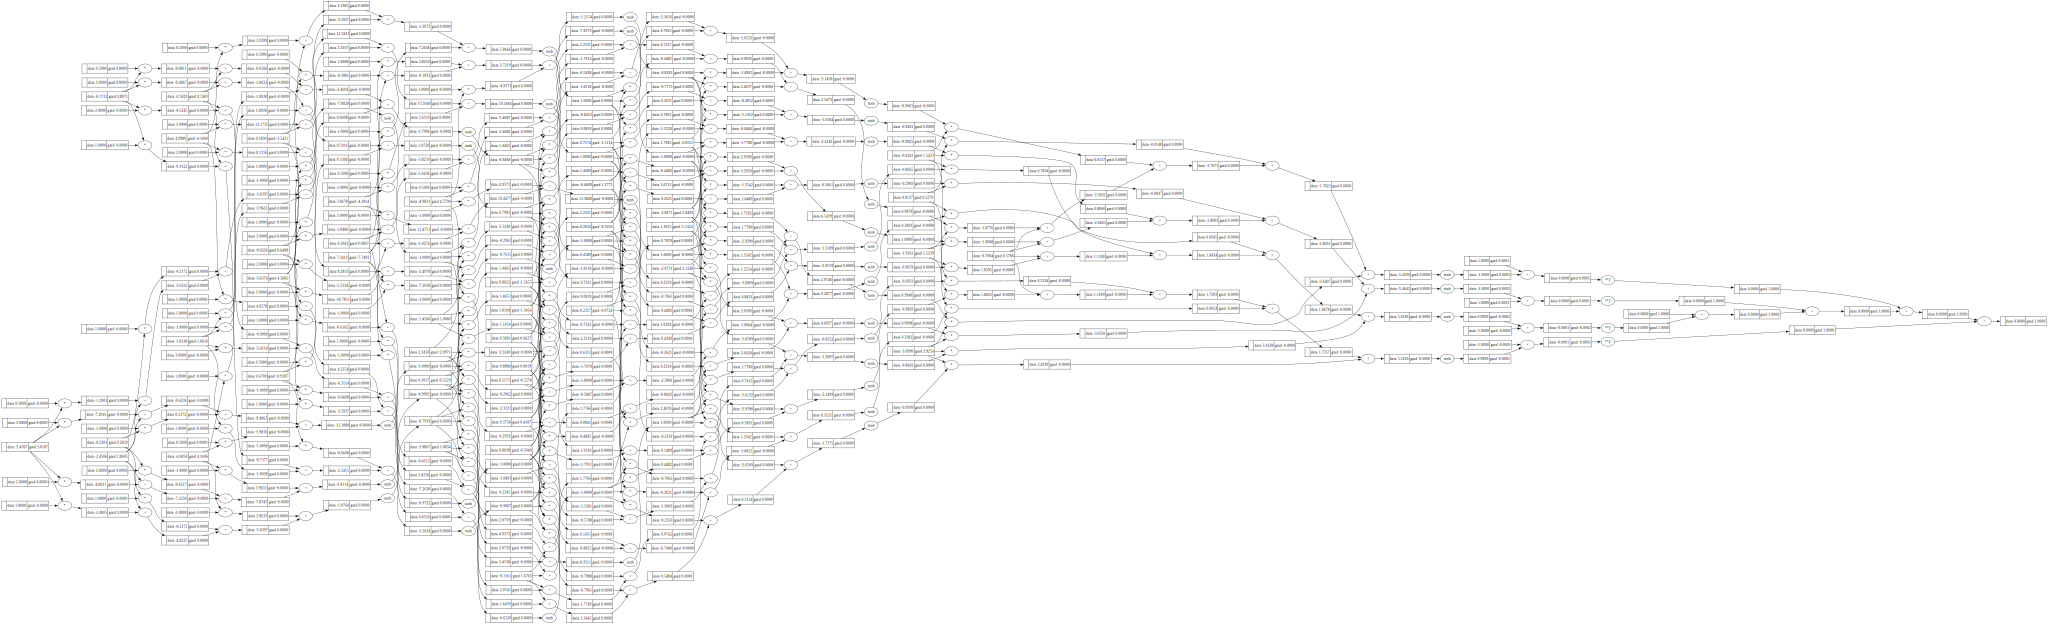

In [49]:
draw_dot(loss)




### 自动训练


In [53]:
#data and label
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0,0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]


# 创建神经网络
n = MLP(3,[4,4,1])


for k in range (20): #轮
    # faward
    ypred = [n(x) for x in xs]
    loss = sum((y1 - y2)**2 for y1,y2 in zip(ys,ypred))
    #清空梯度
    for p in n.parameters():
        p.grad = 0
    # backward
    loss.backward()
    # step
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k ,loss.data)
#可以看出loss值越来越小


0 3.6864303666493736
1 2.6673118551556954
2 2.6352337239413757
3 1.294709648631617
4 0.038342081753324424
5 0.03126702467093523
6 0.02655663121903631
7 0.02317606057483932
8 0.02062205277399428
9 0.018618740848558087
10 0.017001652875530147
11 0.0156663903908788
12 0.014543377594769473
13 0.013584397936000914
14 0.01275494682367005
15 0.012029659535134674
16 0.01138945916198231
17 0.01081971267578297
18 0.010309001698310965
19 0.00984828103023463


In [54]:
ypred
# 可以看出训练也比较成功，接近标签

[Value(data =0.9385870205109451),
 Value(data =-0.9664811038715673),
 Value(data =-0.9637115064189904),
 Value(data =0.9396977959236653)]